# Importing the Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
from functools import partial
from copy import copy
import os

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time
from tqdm import trange

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Plotting

### Dimensions

In [3]:
def set_size_wide(width_pt=426.79135, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return [fig_width_in, fig_height_in]

In [4]:
def set_size_tall(width_pt=426.79135, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * (1 / golden_ratio) * (subplots[0] / subplots[1])

    return [fig_width_in, fig_height_in]

In [5]:
def set_size_square(width_pt=426.79135, fraction=1):
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in 

    return [fig_width_in, fig_height_in]

### Plots

In [6]:
def plotmean(X, Y, Colors = ["tab:gray", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], Name="", Fract=0.35, Line = [1.0]):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.8, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )

  for i in range(len(X)):
    Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i], linewidth = Line[i])

  Ax.set_xlabel(r"{Number of Basis Functions, $\kappa$}")
  Ax.set_ylabel(r"{RMSE, $\sqrt{\frac{1}{N^{\ast}}\norm{\bm{\mu}-\hat{\bm{\mu}}}_{2}^{2}}$}")

  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)

In [7]:
def plotcov(X, Y, Colors = ["tab:gray", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], Name="", Fract=0.35, Line = [1.0]):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.6, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )

  for i in range(len(X)):
    Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i], linewidth = Line[i])

  Ax.set_xlabel(r"{Number of Basis Functions, $\kappa$}")
  Ax.set_ylabel(r"{RMSE, $\sqrt{\frac{1}{N^{\ast}}\norm{\bm{K}-\hat{\bm{K}}}_{F}^{2}}$}")

  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)

In [8]:
def plotfilt(X, Y, ScattX, ScattY, FillX, ErrorBars, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], ScattL="", Name="", Fract=0.35, Legend=False):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  Legfig = plt.figure()
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )
  Lines = [0] * len(X)
  for i in range(len(X)):
    Lines[i] = Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i])

  Ax.fill_between(FillX, *ErrorBars, alpha = 0.3, zorder=1)
  Ax.scatter(ScattX, ScattY, s = 50, label = ScattL, marker = '+', c='r', alpha = 0.8, zorder = 5)
  
  Ax.set_xlabel(r"{Time ($s$)}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")

  Ax.set_xlim([0.0, 1.0])

  Lns, Lbl = Ax.get_legend_handles_labels()
  Legfig.legend(Lns, Lbl, loc='center', ncol = 4, columnspacing = 0.7)

  Ax.lines.pop(-1)
  plt.draw()
  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)
  if Legend:
    Legfig.savefig(Filepath + "/" + Name + 'Legend' + '.pgf', format = 'pgf', bbox_inches = 'tight')

In [9]:
def plotout(X, Y, FillX, ErrorBars, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], Name="", Fract=0.35):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  Legfig = plt.figure()
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )

  for i in range(len(X)):
    Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i], linewidth=0.4 * (2 * i + 1), zorder = i)

  Ax.fill_between(FillX, *ErrorBars, alpha = 0.3, zorder=1)
  
  Ax.set_xlabel(r"{Time ($s$)}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")

  Ax.autoscale(enable=True, axis='x', tight=True)

  Lns, Lbl = Ax.get_legend_handles_labels()
  Legfig.legend(Lns, Lbl, loc='center', ncol = 2)

  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)

In [10]:

def plot_2D(Cov, PredPoints, Title=None, colors='viridis', Name = "",fract=0.4, Min_cov = 0.0, Max_cov = 1.0, ext = [0.0, 1.0, 0.0, 1.0], labels=""):
    """Visualise count data given the index lists"""
    Axsize = set_size_square(fraction=fract)
    # Axsize[1] = Axsize[1]/4
    fsize1 = (Axsize[0]+ 1.5, Axsize[1] + 0.5)
    Fig = plt.figure(figsize=fsize1)
    H = [Size.Scaled(1), Size.Fixed(0.05), Size.Fixed(Axsize[0]*0.05), Size.Fixed(Axsize[0]), 
            Size.Fixed(0.05), Size.Fixed(Axsize[0]*0.05), Size.Scaled(1)]
    V = [Size.Fixed(0.05), Size.Fixed(Axsize[1]), Size.Scaled(1)]
    Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
    Ax = Fig.add_axes(
        Div.get_position(), axes_locator=Div.new_locator(nx=3, ny=1)
    )
    Cax = Fig.add_axes(
        Div.get_position(), axes_locator=Div.new_locator(nx=5, ny=1)
    )
    Dx = PredPoints[1] - PredPoints[0]
    Min_x = np.min(PredPoints)
    Max_x = np.max(PredPoints)
    Ext = [-Dx/2, Max_x + Dx/2, Max_x + Dx/2, -Dx/2]
    My_cmap = copy(cm.get_cmap(colors))
    
    Im = Ax.imshow(Cov, origin='upper', cmap=My_cmap, clim = [Min_cov, Max_cov], vmin = Min_cov, vmax = Max_cov, extent=Ext)

    Col = Fig.colorbar(Im, cax=Cax, ticks = np.linspace(Min_cov, Max_cov, 6), format=lambda x,_:f"{x:.2f}")
    if Title:  plt.title(Title)
    Ax.set_xticks(np.linspace(Min_x, Max_x, 6))
    Ax.set_yticks(np.linspace(Min_x, Max_x, 6))
    Ax.xaxis.tick_top()
    Ax.set_xlabel(r"{$(\tau^{\ast})^{'} (s)$}")
    Ax.xaxis.set_label_position('top') 
    Ax.set_ylabel(r"{$\tau^{\ast} (s)$}")
    Col.set_label(labels)

    Fsize = Fig.get_size_inches()

    Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
    print(Filepath + "/" + Name + '.pgf')
    Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', dpi = 200)
    
    return Fsize

In [11]:
def plot_approx(FSamples, PredPoint, PMean, PCov, Number_F, Num_C, Colors = ["tab:green", "tab:orange"],
            Labels = ["Sample Mean", "Exact Mean"], Name="", Fract=0.35, Legend=False, Actual = False):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  Legfig = plt.figure()
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )

  S2 = np.sqrt(np.diag(PCov))
  Pup = PMean.flatten() + 2 * S2
  Pdown = PMean.flatten() - 2 * S2

  Sammean = np.mean(FSamples, axis = 0)
  Samstd = np.std(FSamples, axis = 0)

  Ax.fill_between(PredPoint.flatten(), Sammean.flatten() - 2 * Samstd.flatten(), Sammean.flatten() + 2 * Samstd.flatten(), alpha = 0.3)

  Ax.plot(PredPoint, PMean, c="tab:orange", zorder=3, label="Exact Mean")
  Ax.scatter(z_arr, indm, c = 'r', marker='+', zorder = 4, label="Inducing Variable")
  Ax.plot(PredPoint, Pup, c = 'k', linestyle = '--', label="Exact 95% Confidence Bar")
  Ax.plot(PredPoint, Pdown, c = 'k', linestyle = '--')
  Gap = Number_F // Num_C
  for i in range(int(Num_C) - 1):
    Ax.plot(PredPoint, FSamples[i * Gap], c = 'tab:blue', alpha = 0.35, linewidth=0.2)
  Ax.plot(PredPoint, FSamples[(int(Num_C) - 1) * Gap], c = 'tab:blue', alpha = 0.35, label=r"Sample, $\bm{\tilde{f}}", linewidth = 0.2)
  Ax.plot(PredPoint, Sammean, label = Labels[0], c=Colors[0], zorder = 3)
  

  Ax.set_xlabel(r"{$\tau^{\ast}(s)$}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")
  Ax.autoscale(enable=True, axis='x', tight=True)

  Lns, Lbl = Ax.get_legend_handles_labels()
  Legfig.legend(Lns, Lbl, loc='center', ncol = 3, columnspacing = 0.7)

  if Actual:
    Ax.lines.pop(-1)

  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)
  if Legend:
    Legfig.savefig(Filepath + "/" + Name + 'Legend' + '.pgf', format = 'pgf', bbox_inches = 'tight')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf')

# Defining SE Covariance

In [12]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

# Creating Test Data

In [13]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [14]:
# Time resolution
time_bin = 0.001

## True Filter

In [15]:
# True variance
sigma_f = 0.4

# True ell
ell_f = 0.05

# Time horizon
fmaxt = 1.0

# Time points for filter
d = np.floor(fmaxt/time_bin).astype(np.int64) 
ftime = np.linspace(0.0, fmaxt, d + 1).reshape((d + 1, 1))

# True covariance matrix
true_cov = Squared_exp(ftime, ftime.T, sigma_f, ell_f)
true_chol = np.linalg.cholesky(true_cov + 1e-6 * np.eye(d + 1))

# Sampling filter
ftrue = true_chol @ random.normal(subkeys[-1], ((d + 1, 1)))

In [16]:
print(d)

1000


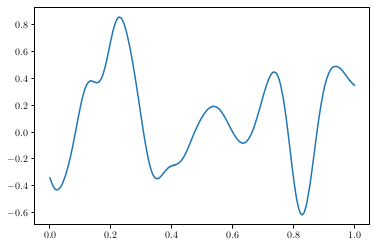

In [17]:
plt.plot(ftime, ftrue)

## Sampling Filter

### Add Noise

In [18]:
# Noise variance
sigma_n = 0.05 
noise_vec = random.normal(subkeys[-2], (d + 1, 1)) * sigma_n
yobs = ftrue

In [19]:
# Number of samples
num_sam = 249

# Window for sampling
lower = int((d + 1) / 4)
upper = int(2 * (d + 1) / 4)
if upper - lower > num_sam:
  indices = np.arange(lower, upper)
  ind_arr = random.choice(subkeys[-2], indices, (num_sam,))
else:
  print('More samples than available in region defined. ' + str(upper - lower) + ' available.')

In [20]:
fsamp = yobs[ind_arr]
samp_t = ftime[ind_arr,:]

## Inducing Points

In [21]:
num_ind = 3
zind = np.arange(lower, upper + 1, (upper - lower)/(num_ind - 1)).astype(np.int32)
z_arr = ftime[zind, :]
u_arr = yobs[zind]

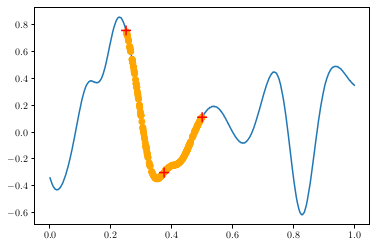

In [22]:
plt.plot(ftime, yobs)
plt.scatter(samp_t, fsamp, c = 'orange', zorder = 3)
plt.scatter(z_arr, u_arr, c='red', marker='+', zorder = 5, s=100)

In [23]:
kmx = Squared_exp(z_arr, samp_t.T, sigma_f, ell_f)
kmm = Squared_exp(z_arr, z_arr.T, sigma_f, ell_f)
kterm = sc.linalg.solve(kmm, kmx, True)
indpres = np.linalg.inv(kmm) + kterm @ kterm.T / (sigma_n ** 2)
indcov = np.linalg.inv(indpres)
indm = indcov @ kterm @ fsamp / (sigma_n ** 2)

In [24]:
fpred_points = ftime.copy()

In [25]:
kmast = Squared_exp(z_arr, fpred_points.T, sigma_f, ell_f)
pterm = jsc.linalg.solve(kmm, kmast, True).T
pmean = pterm @ indm

kastast = Squared_exp(fpred_points, fpred_points.T, sigma_f, ell_f)
pcov = kastast - pterm @ kmast + pterm @ indcov @ pterm.T
s2 = jnp.sqrt(jnp.diag(pcov))

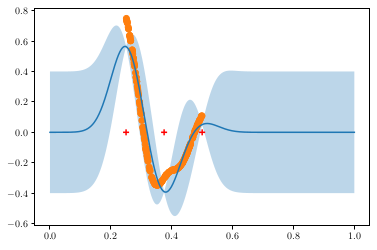

In [26]:
plt.plot(fpred_points, pmean)
plt.fill_between(fpred_points.flatten(), pmean.flatten() - s2, pmean.flatten() + s2, alpha=0.3)
plt.scatter(z_arr, np.zeros_like(z_arr),c = 'r', marker='+')
plt.scatter(samp_t, fsamp)

## Approximate Sampling

In [27]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [28]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [29]:
@partial(jit, static_argnums = range(5,8))
def Expected_Term(Sigma_f, Ell, Z_Vector, Ind_Mean, Ind_Cov, 
                Number_F, Num_Base, M, F_PredTime, Subkeys):
  # Expectation term
  Thetas = random.normal(Subkeys[0], (1, 1, Num_Base)) * (1.0 / Ell)

  Taus = random.uniform(Subkeys[1], (1, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Num_Base, 1))

  Constant = Sigma_f * jnp.sqrt(2.0 / Num_Base)

  ZT = Z_Vector.T
   
  Phi1 = Constant * jnp.cos(F_PredTime * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f, Ell)
  Knm = Squared_exp(F_PredTime, ZT, Sigma_f, Ell)

  V_uChol = jnp.linalg.cholesky(Ind_Cov + 1e-6 * jnp.eye(M))

  U_Samples = Ind_Mean + V_uChol @ random.normal(Subkeys[3], (Number_F, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)
  F_Samples = Phi1 @ Omegas + Knm @ Vu
  
  return F_Samples

In [40]:
test_num_f = 5000
test_num_b = 10
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
num_pred = np.shape(fpred_points)[0]

In [41]:
fsamples = Expected_Term(sigma_f, ell_f, z_arr, indm, indcov, test_num_f, test_num_b, num_ind, fpred_points, test_subkeys)

In [42]:
pcov.shape

(1001, 1001)

In [43]:
truesamps = pmean + np.linalg.cholesky(pcov + 1e-6 * np.eye(num_pred)) @ random.normal(test_key, (test_num_f, num_pred, 1))

In [44]:
print(fsamples.shape)

(5000, 1001, 1)


# Plot

/home/sgome/Project/Reports/Final-Report/Figures/Samcurve10.pgf


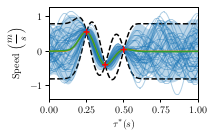

<Figure size 432x288 with 0 Axes>

In [45]:
plot_approx(fsamples, fpred_points, pmean, pcov, test_num_f, 50, Name="Samcurve" + str(test_num_b))

/home/sgome/Project/Reports/Final-Report/Figures/Trucurve.pgf


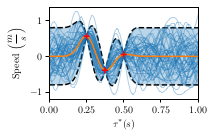

<Figure size 432x288 with 0 Axes>

In [46]:
plot_approx(truesamps, fpred_points, pmean, pcov, test_num_f, 50, Name="Trucurve", Actual=True, Legend=True)

In [37]:
fsamflat = fsamples.reshape(*np.shape(fsamples)[:-1])

In [38]:
covres = 0.05
mincov = (np.min(pcov) // covres)*covres
maxcov = (np.max(pcov) // covres + 1)*covres

In [39]:
plot_2D(pcov, fpred_points.flatten(), Min_cov=mincov, Max_cov=maxcov, labels=r"{Covariance, $(\bm{\Sigma})_{i, j}$}", Name="Actpredcov", fract = 0.3)

/home/sgome/Project/Reports/Final-Report/Figures/Actpredcov.pgf


array([3.27165359, 2.27165359])

Error in callback <function flush_figures at 0x7f8a43f69f70> (for post_execute):


KeyboardInterrupt: 

/home/sgome/Project/Reports/Final-Report/Figures/Estpredcov500.pgf


array([3.27165359, 2.27165359])

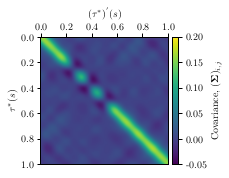

In [ ]:
plot_2D(np.cov(fsamflat.T), fpred_points.flatten(), Min_cov=mincov, Max_cov=maxcov, labels=r"{Covariance, $(\bm{\Sigma})_{i, j}$}", Name="Estpredcov" + str(test_num_b), fract=0.3)

# Convergence

In [ ]:
numpoint = 100
base_test = np.linspace(1, 2000, numpoint).astype(np.int32)

In [ ]:
meanerror = np.zeros(numpoint)
varerror = np.zeros(numpoint)

In [ ]:
for i in trange(numpoint):
  f_sam = Expected_Term(sigma_f, ell_f, z_arr, 
          indm, indcov, test_num_f, base_test[i], num_ind, 
          fpred_points, test_subkeys)
  f_samflat = f_sam.reshape(*np.shape(f_sam)[:-1])
  meanest = np.mean(f_samflat, axis = 0)
  covest = np.cov(f_samflat.T)
  rmsvar = np.sqrt(np.mean(np.square(covest - pcov)))
  rmsmean =  np.sqrt(np.mean(np.square(meanest - pmean)))
  varerror[i] = rmsvar
  meanerror[i] = rmsmean

100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


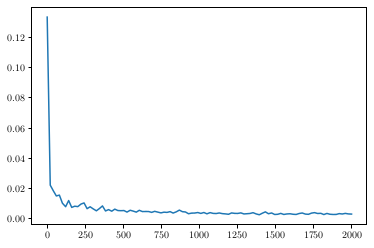

In [ ]:
plt.plot(base_test, varerror)

/home/sgome/Project/Reports/Final-Report/Figures/CovError.pgf


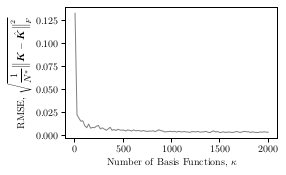

In [ ]:
plotcov([base_test], [varerror], Fract=0.5, Name="CovError")

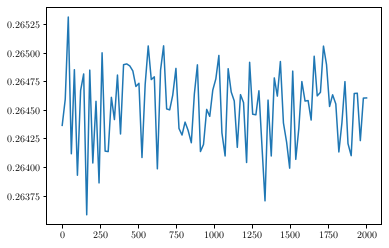

In [ ]:
plt.plot(base_test, meanerror)

/home/sgome/Project/Reports/Final-Report/Figures/MeanError.pgf


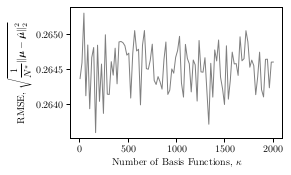

In [ ]:
plotmean([base_test], [meanerror], Fract=0.5, Name="MeanError")